<a href="https://colab.research.google.com/github/akansh12/monai-tutorial/blob/main/MONAI/MONAI_tutorial_2(2D_seg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 816 kB 7.3 MB/s 


### What are these?
- Decollate_batch
- Dice Metric

In [2]:
import logging
import os
import sys
import tempfile
from glob import glob

import torch
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    Compose,
    LoadImaged,
    RandCropByPosNegLabeld,
    RandRotate90d,
    ScaleIntensityd,
    EnsureTyped,
    EnsureType,
)
from monai.visualize import plot_2d_or_3d_image


In [3]:
import matplotlib.pyplot as plt

In [ ]:
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [7]:
os.makedirs("./test_data/")
tempdir = "./test_data"

In [8]:
# create a temporary directory and 40 random image, mask pairs
print(f"generating synthetic data to {tempdir} (this may take a while)")
for i in range(40):
    im, seg = create_test_image_2d(128, 128, num_seg_classes=1)
    Image.fromarray((im * 255).astype("uint8")).save(os.path.join(tempdir, f"img{i:d}.png"))
    Image.fromarray((seg * 255).astype("uint8")).save(os.path.join(tempdir, f"seg{i:d}.png"))

images = sorted(glob(os.path.join(tempdir, "img*.png")))
segs = sorted(glob(os.path.join(tempdir, "seg*.png")))

generating synthetic data to ./test_data (this may take a while)


In [9]:
train_files = [{"img": img, "seg": seg} for img, seg in zip(images[:20], segs[:20])]
val_files = [{"img": img, "seg": seg} for img, seg in zip(images[-20:], segs[-20:])]

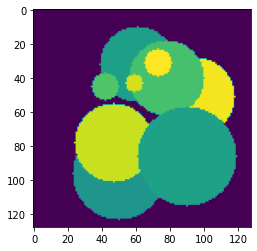

In [10]:
eg_img = plt.imread(images[0])
eg_label = plt.imread(segs[0])
plt.imshow(eg_img)

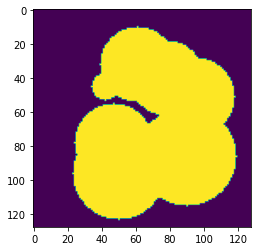

In [11]:
plt.imshow(eg_label)

In [12]:
eg_label.shape

(128, 128)

In [29]:
train_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        AddChanneld(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        # RandCropByPosNegLabeld(
        #     keys=["img", "seg"], label_key="seg", spatial_size=[96, 96], pos=1, neg=1, num_samples=4
        # ),
        RandRotate90d(keys=["img", "seg"], prob=0.5, spatial_axes=[0, 1]),
        EnsureTyped(keys=["img", "seg"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["img", "seg"]),
        AddChanneld(keys=["img", "seg"]),
        ScaleIntensityd(keys=["img", "seg"]),
        EnsureTyped(keys=["img", "seg"]),
    ]
)

post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])



In [30]:
check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
# use batch_size=2 to load images and use RandCropByPosNegLabeld to generate 2 x 4 images for network training
check_loader = DataLoader(check_ds, batch_size=2, num_workers=2, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data["img"].shape, check_data["seg"].shape)


torch.Size([2, 1, 128, 128]) torch.Size([2, 1, 128, 128])


In [35]:
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2, collate_fn=list_data_collate)

In [36]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
model = monai.networks.nets.UNet(
      spatial_dims=2,
      in_channels=1,
      out_channels=1,
      channels=(16, 32, 64, 128, 256),
      strides=(2, 2, 2, 2),
      num_res_units=2,
  ).to(device)

In [39]:
for batch_data in train_loader:
  img, label = batch_data["img"].to(device), batch_data["seg"].to(device)
  break

In [ ]:
!pip install torchviz
from torchviz import make_dot

In [ ]:
x = torch.zeros(1, 1, 128, 128, dtype=torch.float, requires_grad=False)
out = model(x.to(device))
make_dot(out)

In [45]:
post_trans(out).shape

torch.Size([1, 1, 128, 128])

In [41]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

In [46]:
from pickle import decode_long
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
for epoch in range(10):
  model.train()
  epoch_loss = 0
  step = 0
  for batch_data in train_loader:
    step += 1
    inputs, labels = batch_data['img'].to(device), batch_data['seg'].to(device)
    outputs = model(inputs)
    optimizer.zero_grad()
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_len = len(train_ds) // train_loader.batch_size
    print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
  epoch_loss /= step
  epoch_loss_values.append(epoch_loss)
  print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

  if (epoch + 1) % val_interval == 0: 
    model.eval();
    with torch.no_grad():
      val_image = None
      val_label = None
      val_outputs = None
      for val_data in val_loader:
        val_images, val_labels = val_data['img'].to(device), val_data['seg'].to(device)
        # roi_size = (96,96)
        # sw_batch_size = 4
        # val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
        # val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
        val_outputs = post_trans(model(val_images))

        dice_metric(y_pred = val_outputs, y = val_labels)

      metric = dice_metric.aggregate().item()
      dice_metric.reset()
      metric_values.append(metric)
      if metric > best_metric:
        best_metric = metric
        best_metric_epoch = epoch + 1

        torch.save(model.state_dict(), "best_metric_model_segmentation2d_dict.pth")
        print("saved new best metric model")
      print(
          "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
              epoch + 1, metric, best_metric, best_metric_epoch
          )
      )
      writer.add_scalar("val_mean_dice", metric, epoch + 1)
              # plot the last model output as GIF image in TensorBoard with the corresponding image and label
      plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
      plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
      plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
writer.close()


1/10, train_loss: 0.4692
2/10, train_loss: 0.4124
3/10, train_loss: 0.3647
4/10, train_loss: 0.3202
5/10, train_loss: 0.3331
6/10, train_loss: 0.3480
7/10, train_loss: 0.3943
8/10, train_loss: 0.3220
9/10, train_loss: 0.2962
10/10, train_loss: 0.3140
epoch 1 average loss: 0.3574
1/10, train_loss: 0.3244
2/10, train_loss: 0.2866
3/10, train_loss: 0.3502
4/10, train_loss: 0.3086
5/10, train_loss: 0.3243
6/10, train_loss: 0.3164
7/10, train_loss: 0.2866
8/10, train_loss: 0.2870
9/10, train_loss: 0.3077
10/10, train_loss: 0.2911
epoch 2 average loss: 0.3083
saved new best metric model
current epoch: 2 current mean dice: 0.8948 best mean dice: 0.8948 at epoch 2
1/10, train_loss: 0.2662
2/10, train_loss: 0.2984
3/10, train_loss: 0.2889
4/10, train_loss: 0.2611
5/10, train_loss: 0.3385
6/10, train_loss: 0.2974
7/10, train_loss: 0.2970
8/10, train_loss: 0.3035
9/10, train_loss: 0.3324
10/10, train_loss: 0.2830
epoch 3 average loss: 0.2966
1/10, train_loss: 0.2620
2/10, train_loss: 0.2640
3/10,

In [55]:
for x in val_loader:
  break

In [60]:
img = x['img'].to(device)
label = x['seg'].to(device)

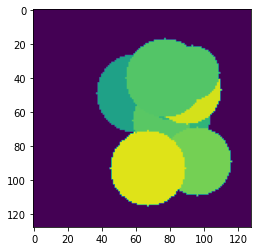

In [59]:
plt.imshow(img[0][0].to('cpu').numpy())

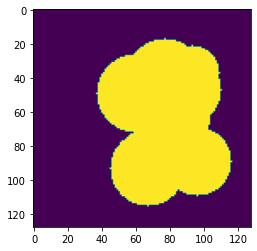

In [61]:
plt.imshow(label[0][0].to('cpu').numpy())

In [63]:
out = model(img)

In [65]:
out = post_trans(out)

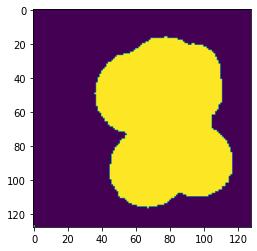

In [66]:
plt.imshow(out[0][0].to('cpu').numpy())

In [67]:
dice_metric(y_pred = label, y = out)

tensor([[0.9725]], device='cuda:0')

In [78]:
dice_metric(y_pred = label, y = out)

tensor([[0.9725]], device='cuda:0')

In [73]:
dice_metric.aggregate().item()

0.9724879264831543

In [81]:
dice_metric.reset()

In [82]:
dice_metric.aggregate()

ValueError: ignored